# インポート

In [1]:
import pandas as pd
import pandas_profiling as pdp
from IPython.display import display
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as ticker
import docker
import psycopg2
import itertools
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
sns.set(style="darkgrid", palette="muted", color_codes=True)
plt.rcParams['font.family']='HGMaruGothicMPRO'
%matplotlib inline

# データのインポート

In [2]:
data = pd.read_csv('./FIFA 2018 Statistics.csv',header=0)

In [3]:
groupA=['Uruguay','Russia','Saudi Arabia','Egypt']
groupB=['Spain','Portugal','Iran','Morocco']
groupC=['France','Denmark','Peru','Australia']
groupD=['Croatia','Argentina','Nigeria','Iceland']
groupE=['Brazil','Switzerland','Serbia','Costa Rica']
groupF=['Sweden','Mexico','Korea Republic','Germany']
groupG=['Belgium','England','Tunisia','Panama']
groupH=['Colombia','Japan','Senegal','Poland']

In [4]:
columns = data.columns # カラムの情報

In [5]:
columns

Index(['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %',
       'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')

In [6]:
teamdataA = data[data['Team'].isin(groupA)]
teamdataB = data[data['Team'].isin(groupB)]
teamdataC = data[data['Team'].isin(groupC)]
teamdataD = data[data['Team'].isin(groupD)]
teamdataE = data[data['Team'].isin(groupE)]
teamdataF = data[data['Team'].isin(groupF)]
teamdataG = data[data['Team'].isin(groupG)]
teamdataH = data[data['Team'].isin(groupH)]

In [7]:
o_e = data.index%2
o_e = o_e.to_frame().rename(columns={0:'o_e'}).reset_index(drop=True)
data['o_e'] = o_e

In [8]:
matchdata = data.merge(data.shift(1).where(data['o_e'].astype(bool),data.shift(-1))
                  ,left_index=True,right_index=True,suffixes=('_win','_lose'))

In [9]:
matchdata.iloc[0].T

Date_win                         14-06-2018
Team_win                             Russia
Opponent_win                   Saudi Arabia
Goal Scored_win                           5
Ball Possession %_win                    40
Attempts_win                             13
On-Target_win                             7
Off-Target_win                            3
Blocked_win                               3
Corners_win                               6
Offsides_win                              3
Free Kicks_win                           11
Saves_win                                 0
Pass Accuracy %_win                      78
Passes_win                              306
Distance Covered (Kms)_win              118
Fouls Committed_win                      22
Yellow Card_win                           0
Yellow & Red_win                          0
Red_win                                   0
Man of the Match_win                    Yes
1st Goal_win                             12
Round_win                       

In [10]:
matchdata = matchdata[(matchdata['Goal Scored_win'] > matchdata['Goal Scored_lose'])|
                      ((matchdata['PSO_win']=='Yes')&(matchdata['Goals in PSO_win'] > matchdata['Goals in PSO_lose']))|
                      ((matchdata['o_e_win'] == 0)&(matchdata['PSO_win']=='No')&(matchdata['Goal Scored_win'] == matchdata['Goal Scored_lose']))]

In [11]:
matchdataA = matchdata[matchdata['Team_win'].isin(groupA)]
matchdataB = matchdata[matchdata['Team_win'].isin(groupB)]
matchdataC = matchdata[matchdata['Team_win'].isin(groupC)]
matchdataD = matchdata[matchdata['Team_win'].isin(groupD)]
matchdataE = matchdata[matchdata['Team_win'].isin(groupE)]
matchdataF = matchdata[matchdata['Team_win'].isin(groupF)]
matchdataG = matchdata[matchdata['Team_win'].isin(groupG)]
matchdataH = matchdata[matchdata['Team_win'].isin(groupH)]

In [12]:
matchdata

,Date_win,Team_win,Opponent_win,Goal Scored_win,Ball Possession %_win,Attempts_win,On-Target_win,Off-Target_win,Blocked_win,Corners_win,...,Yellow & Red_lose,Red_lose,Man of the Match_lose,1st Goal_lose,Round_lose,PSO_lose,Goals in PSO_lose,Own goals_lose,Own goal Time_lose,o_e_lose
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0.0,0.0,No,NaN,Group Stage,No,0.0,NaN,NaN,1.0
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0.0,0.0,No,NaN,Group Stage,No,0.0,NaN,NaN,0.0
5,15-06-2018,Iran,Morocco,1,36,8,2,5,1,2,...,0.0,0.0,No,NaN,Group Stage,No,0.0,1.0,90.0,0.0
6,15-06-2018,Portugal,Spain,3,39,8,3,2,3,4,...,0.0,0.0,Yes,24.0,Group Stage,No,0.0,NaN,NaN,1.0
8,16-06-2018,France,Australia,2,51,12,5,4,3,5,...,0.0,0.0,No,62.0,Group Stage,No,0.0,1.0,81.0,1.0
10,16-06-2018,Argentina,Iceland,1,72,26,7,9,10,10,...,0.0,0.0,Yes,23.0,Group Stage,No,0.0,NaN,NaN,1.0
13,16-06-2018,Denmark,Peru,1,48,10,3,5,2,7,...,0.0,0.0,No,NaN,Group Stage,No,0.0,NaN,NaN,0.0
14,17-06-2018,Croatia,Nigeria,2,54,11,2,7,2,6,...,0.0,0.0,No,NaN,Group Stage,No,0.0,1.0,32.0,1.0
17,17-06-2018,Serbia,Costa Rica,1,50,10,3,5,2,4,...,0.0,0.0,No,NaN,Group Stage,No,0.0,NaN,NaN,0.0
19,17-06-2018,Mexico,Germany,1,40,12,4,6,2,1,...,0.0,0.0,Yes,NaN,Group Stage,No,0.0,NaN,NaN,0.0


C:\Users\ryu_sugimoto\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


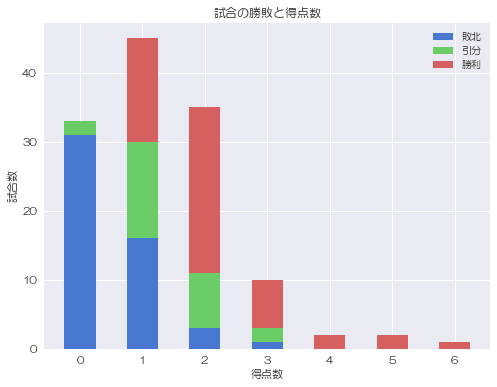

In [49]:
fig = plt.figure(figsize=(8,6))
plt.title('試合の勝敗と得点数')
plt.xlabel('得点数')
plt.ylabel('試合数')
plt.hist((matchdata[matchdata['Goal Scored_win']>matchdata['Goal Scored_lose']]['Goal Scored_lose'],
          matchdata[matchdata['Goal Scored_win']==matchdata['Goal Scored_lose']]['Goal Scored_win'].append(matchdata[matchdata['Goal Scored_win']==matchdata['Goal Scored_lose']]['Goal Scored_lose']),
          matchdata[matchdata['Goal Scored_win']>matchdata['Goal Scored_lose']]['Goal Scored_win']),
          histtype='barstacked',bins=np.arange(-0.25,6.75,0.5))
plt.legend(['敗北','引分','勝利'])
plt.show()

# groupHに着目

In [13]:
teamdataH

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
28,19-06-2018,Colombia,Japan,1,41,8,3,1,4,3,...,2,0,1,No,39.0,Group Stage,No,0,NaN,NaN
29,19-06-2018,Japan,Colombia,2,59,14,6,5,3,6,...,1,0,0,Yes,6.0,Group Stage,No,0,NaN,NaN
30,19-06-2018,Poland,Senegal,1,57,10,4,5,1,3,...,1,0,0,No,37.0,Group Stage,No,0,1.0,37.0
31,19-06-2018,Senegal,Poland,2,43,8,2,4,2,3,...,2,0,0,Yes,60.0,Group Stage,No,0,NaN,NaN
60,24-06-2018,Japan,Senegal,2,54,7,3,2,2,2,...,2,0,0,No,34.0,Group Stage,No,0,NaN,NaN
61,24-06-2018,Senegal,Japan,2,46,14,7,5,2,5,...,3,0,0,Yes,11.0,Group Stage,No,0,NaN,NaN
62,24-06-2018,Poland,Colombia,0,45,9,2,3,4,7,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
63,24-06-2018,Colombia,Poland,3,55,13,3,5,5,5,...,0,0,0,Yes,40.0,Group Stage,No,0,NaN,NaN
88,28-06-2018,Japan,Poland,0,54,10,3,4,3,5,...,1,0,0,No,NaN,Group Stage,No,0,NaN,NaN
89,28-06-2018,Poland,Japan,1,46,11,2,5,4,7,...,0,0,0,Yes,59.0,Group Stage,No,0,NaN,NaN


In [53]:
matchdataH[['Team_win','Goal Scored_win','Goal Scored_lose','Team_lose']]

,Team_win,Goal Scored_win,Goal Scored_lose,Team_lose
29,Japan,2,1.0,Colombia
31,Senegal,2,1.0,Poland
60,Japan,2,2.0,Senegal
63,Colombia,3,0.0,Poland
89,Poland,1,0.0,Japan
91,Colombia,1,0.0,Senegal


In [64]:
teamdataH_group = teamdataH[teamdataH['Round']=='Group Stage']
print(teamdataH_group.columns)
teamdataH_group = teamdataH_group.set_index(['Team','Opponent']).drop(['PSO','Goals in PSO','Date','Round','Man of the Match'],axis=1)

Index(['Date', 'Team', 'Opponent', 'Goal Scored', 'Ball Possession %',
       'Attempts', 'On-Target', 'Off-Target', 'Blocked', 'Corners', 'Offsides',
       'Free Kicks', 'Saves', 'Pass Accuracy %', 'Passes',
       'Distance Covered (Kms)', 'Fouls Committed', 'Yellow Card',
       'Yellow & Red', 'Red', 'Man of the Match', '1st Goal', 'Round', 'PSO',
       'Goals in PSO', 'Own goals', 'Own goal Time'],
      dtype='object')


In [65]:
teamdataH_group

,,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,1st Goal,Own goals,Own goal Time
Team,Opponent,,,,,,,,,,,,,,,,,,,,
Colombia,Japan,1,41,8,3,1,4,3,2,10,4,82,352,93,15,2,0,1,39.0,NaN,NaN
Japan,Colombia,2,59,14,6,5,3,6,1,17,2,87,565,101,9,1,0,0,6.0,NaN,NaN
Poland,Senegal,1,57,10,4,5,1,3,3,18,1,88,552,110,8,1,0,0,37.0,1.0,37.0
Senegal,Poland,2,43,8,2,4,2,3,3,11,3,81,328,107,15,2,0,0,60.0,NaN,NaN
Japan,Senegal,2,54,7,3,2,2,2,2,18,5,84,449,105,8,2,0,0,34.0,NaN,NaN
Senegal,Japan,2,46,14,7,5,2,5,4,10,1,79,338,102,14,3,0,0,11.0,NaN,NaN
Poland,Colombia,0,45,9,2,3,4,7,1,11,0,79,424,107,15,2,0,0,NaN,NaN,NaN
Colombia,Poland,3,55,13,3,5,5,5,1,16,2,82,514,108,10,0,0,0,40.0,NaN,NaN
Japan,Poland,0,54,10,3,4,3,5,1,8,2,86,557,83,11,1,0,0,NaN,NaN,NaN


In [72]:
matchdata['Own goals_win'] = matchdata['Own goals_win'].fillna(0)
matchdata['Own goals_lose'] = matchdata['Own goals_lose'].fillna(0)

In [81]:
teamdataH_group.sort_index().unstack('Opponent')

Goal Scored                      Ball Possession %               \
Opponent    Colombia Japan Poland Senegal          Colombia Japan Poland   
Team                                                                       
Colombia         NaN   1.0    3.0     1.0               NaN  41.0   55.0   
Japan            2.0   NaN    0.0     2.0              59.0   NaN   54.0   
Poland           0.0   1.0    NaN     1.0              45.0  46.0    NaN   
Senegal          0.0   2.0    2.0     NaN              43.0  46.0   43.0   

                 Attempts         ...   1st Goal         Own goals        \
Opponent Senegal Colombia Japan   ...     Poland Senegal  Colombia Japan   
Team                              ...                                      
Colombia    57.0      NaN   8.0   ...       40.0    74.0       NaN   NaN   
Japan       54.0     14.0   NaN   ...        NaN    34.0       NaN   NaN   
Poland      57.0      9.0  11.0   ...        NaN    37.0       NaN   NaN   
Senegal      NaN      8.0  14.0   ...       60.0     NaN       NaN   NaN   

                        Own goal Time                       
Opponent Poland Senegal      Colombia Japan Poland Senegal  
Team                                                        
Colombia    NaN     NaN           NaN   NaN    NaN     NaN  
Japan       NaN     NaN           NaN   NaN    NaN     NaN  
Poland      NaN     1.0           NaN   NaN    NaN    37.0  
Senegal     NaN     NaN           NaN   NaN    NaN     NaN  

[4 rows x 80 columns]